<a href="https://colab.research.google.com/github/od41/ai-agents-from-scratch/blob/main/Youtube__Browser_Use_Agent_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install playwright

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 11.9 MB/s eta 0:00:00


In [2]:
!playwright install --with-deps chromium

Installing dependencies...
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://de

In [17]:
from playwright.async_api import async_playwright

p = await async_playwright().start()
browser = await p.chromium.launch(headless=True)
context = await browser.new_context()
page = await context.new_page()

In [ ]:
await page.goto('https://youtube.com/')
await page.wait_for_load_state()

In [18]:
from io import BytesIO
from PIL import Image as PILImage
from IPython.display import display

async def display_screenshot(current_page):
  screenshot = await current_page.screenshot()
  img = PILImage.open(BytesIO(screenshot))

  width, height = img.size
  new_width = int(width * 0.5)
  new_height = int(height * 0.5)
  img = img.resize((new_width, new_height))
  return display(img)

# await display_screenshot(page)

In [19]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=userdata.get("TOGETHER_API_KEY")
)

tools = [{
    "type": "function",
    "function": {
        "name": "load_page",
        "description": "Go to a webpage.",
        "parameters": {
            "type": "object",
            "properties": {
                "url": {
                    "type": "string"
                }
            },
            "required": [
                "url"
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}, {
    "type": "function",
    "function": {
        "name": "click_element",
        "description": "Click on an element by ID.",
        "parameters": {
            "type": "object",
            "properties": {
                "element_id": {
                    "type": "number"
                }
            },
            "required": [
                "element_id"
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}, {
  "type": "function",
  "function": {
    "name": "text_input",
    "description": "Uses Playwright to input the provided text into a specified input field.",
    "parameters": {
      "type": "object",
      "properties": {
        "element_selector": {
          "type": "number",
          "description": "The list index within input_elements that corresponds to the specified input field"
        },
        "text": {
          "type": "string",
          "description": "The text to be entered into the input field."
        }
      },
      "required": [
        "element_selector",
        "text"
      ],
      "additionalProperties": False,
      "examples": [
        {
          "element_selector": "#username-input",
          "text": "exampleUser123"
        }
      ]
    },
    "strict": True
  }
}
]



In [24]:
import json
from pprint import pprint

In [28]:
clickable_elements = []

async def get_clickable_elements():
  global clickable_elements

  await page.wait_for_load_state()
  clickable_elements = await page.query_selector_all('a, button, [role="button"], [onclick]')
  labeled_elements = dict()

  for index, element in enumerate(clickable_elements):
    text = await element.inner_text()
    cleaned_text = " ".join(text.split())
    if text and await element.is_visible():
      labeled_elements[index] = cleaned_text

  return "The page has loaded and the following element IDs can be clicked " + json.dumps(labeled_elements)


input_elements = []

async def get_input_elements():
    """
    Grabs all input elements from the web page, cleans their text labels, and returns them as a JSON string.

    The label is extracted from the input's "placeholder" attribute.

    Args:
        page: A Playwright Page instance.

    Returns:
        A string combining an informational message and a JSON string mapping each input element index to its cleaned label.
    """
    global input_elements

    await page.wait_for_load_state()
    input_elements = await page.query_selector_all("input")
    labeled_elements = {}

    for index, element in enumerate(input_elements):
        text = await element.get_attribute("placeholder")
        cleaned_text = " ".join(text.split()) if text else ""
        if text and await element.is_visible():
            labeled_elements[index] = cleaned_text

    return " and the following input element labels are: " + json.dumps(labeled_elements)


async def load_page(url, current_page):
  await current_page.goto(url)
  return f"{await get_clickable_elements()} {await get_input_elements()}"

async def click_element(element_id):
  await clickable_elements[element_id].click()
  return (await get_clickable_elements(), await get_input_elements())

async def text_input(element_id, text):
    """
    Inputs the provided text into the specified input field.

    Args:
        element_id (int): The index of the target input field in the input_fields list.
        text (str): The text to be entered into the input field.

    Returns:
        The updated state from get_clickable_elements (or any other relevant state).
    """
    pprint(input_elements)
    await input_elements[element_id].fill(text)


In [21]:
# returns username
def get_username():
  return userdata.get("USER_EMAIL")

# returns pw
def get_pw():
  return userdata.get("USER_PASS")

clickable els: [<JSHandle preview=JSHandle@<yt-icon-button role="button" aria-label="Close player" class="style-scope ytd-miniplayer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button role="button" aria-label="Expand" class="style-scope ytd-miniplayer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-label="Expand" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button toggleable="" role="button" id="trailing-button" aria-label="Collapse" class="style-scope ytd-playlist-panel-renderer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-label="Collapse" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button role="button" id="back-button" aria-label="Back" class="style-scope ytd-masthead">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-labe

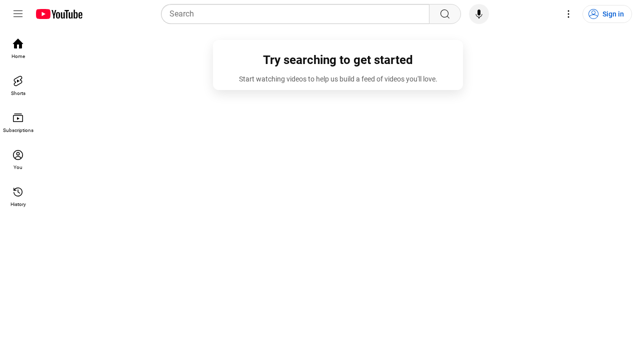

clickable els: [<JSHandle preview=JSHandle@<yt-icon-button role="button" aria-label="Close player" class="style-scope ytd-miniplayer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button role="button" aria-label="Expand" class="style-scope ytd-miniplayer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-label="Expand" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button toggleable="" role="button" id="trailing-button" aria-label="Collapse" class="style-scope ytd-playlist-panel-renderer">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-label="Collapse" class="style-scope yt-icon-button">…</button>>, <JSHandle preview=JSHandle@<yt-icon-button role="button" id="back-button" aria-label="Back" class="style-scope ytd-masthead">…</yt-icon-button>>, <JSHandle preview=JSHandle@<button id="button" aria-labe

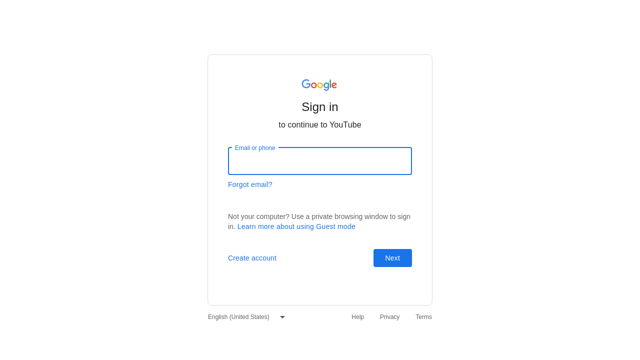

InternalServerError: Error code: 500 - {'id': '90e7209e4dd9d6eb', 'error': {'message': 'Internal server error', 'type': 'server_error', 'param': None, 'code': None}}

In [30]:
chat_history = [
    {
        "role": "system",
        "content": """
          You are a social media engagement agent.

          Given an instruction from a user you might have to:
          - navigate to a website
          - login to a platform with a username and password
          - interact with content e.g liking or disliking
          - comment on content

          Use the following format:

        """
      },
       {"role": "user",
        "content": "Sign in to youtube.com"
        # "content": "Go to youtube.com, signin by clicking the signin button, open a random video you see and leave a comment. Return a link to the video that was viewed and commented on in the final status and also a link to the comment itself."
        }
    ]

dump = """
      Task: the input task you must complete
      Thought: you should always think about what to do
      Action: the action to take, should be ONLY one of [load_page, click_element, text_input]
      Action Input: the input to the action
      Observation: the result of the action
      ... (the Thought/Action/Observation can repeat any number of times)
      Thought: I now know the final status
      Final Status: the status of completion to the original input task"""

while True:

  completion = client.chat.completions.create(
      model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
      messages=chat_history,
      tools=tools
  )

  print(f"clickable els: {clickable_elements}")
  print(f"input els: {input_elements}")

  print(f"message: {completion.choices[0].message.content}")
  print(f"tool_calls {completion.choices[0].message.tool_calls}")

  tool_calls = completion.choices[0].message.tool_calls
  if tool_calls:
    tool_call = tool_calls[0]
    # for tool_call in tool_calls:
    print(f"current tool>> {tool_call}")
    chat_history.append(completion.choices[0].message)
    tool_call_name = tool_call.function.name

    if tool_call_name == "load_page":
      url = json.loads(tool_call.function.arguments)["url"]
      result = await load_page(url, page)
      await display_screenshot(page)
      chat_history.append(
          {"role": "function", "name": tool_call_name, "content": result }
      )

    if tool_call_name == "click_element":
      element_id = json.loads(tool_call.function.arguments)["element_id"]
      result = await click_element(element_id)
      await display_screenshot(page)
      chat_history.append(
          {"role": "function", "name": tool_call_name, "content": result}
      )
    if tool_call_name == "text_input":
      element_selector = json.loads(tool_call.function.arguments)["element_selector"]
      text = json.loads(tool_call.function.arguments)["text"]
      if(text == "your_username"):
        text = get_username()
      elif (text == "your_password"):
        text = get_pw()
      print(element_selector, text)
      result = await text_input(element_selector, text)
      await display_screenshot(page)
      chat_history.append(
          {"role": "function", "name": tool_call_name, "content": result}
      )
  else:
    break

In [ ]:
pprint(input_elements)

[<JSHandle preview=JSHandle@<input type="text" role="combobox" autocorrect="off" aria-controls="i0" autocomplete="off" name="search_query" aria-expanded="true" placeholder="Search" aria-autocomplete="list" class="ytSearchboxComponentInput yt-searchbox-input title"/>>,
 <JSHandle preview=JSHandle@<input id="search" type="text" tabindex="0" autocorrect="off" autocomplete="off" spellcheck="false" name="search_query" aria-label="Search" placeholder="Search" autocapitalize="none"/>>,
 <JSHandle preview=JSHandle@<input checked="true" type="checkbox" class="ytp-share-panel-include-playlist-checkbox"/>>]


[{'content': '\n'
             '          You are a social media engagement agent.\n'
             '\n'
             '          Given an instruction from a user you might have to:\n'
             '          - navigate to a website\n'
             '          - login to a platform with a username and password\n'
             '          - interact with content e.g liking or disliking\n'
             '          - comment on content\n'
             '\n'
             '          Use the following format:\n'
             '\n'
             '          Task: the input task you must complete\n'
             '          Thought: you should always think about what to do\n'
             '          Action: the action to take, should be one of '
             '[load_page, click_element, text_input]\n'
             '          Action Input: the input to the action\n'
             '          Observation: the result of the action\n'
             '          ... (the Thought/Action/Observation can repeat any '

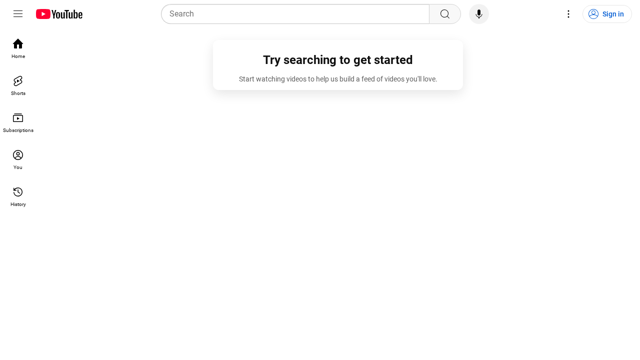

In [ ]:
pprint(chat_history)
await display_screenshot(page)

In [ ]:
await clickable_elements[3].click()